In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa as lib
import subprocess
import soundfile as sf
import librosa.display

%matplotlib inline
%config IPCompleter.greedy=True

sr=48000 # Defining the sample rate

In [3]:
def apply_filter_python(filt, input_file, output_file):
    """Applies filter using lfilter2() in SciPy"""
    audio = lib.load(input_file, sr=sr)[0] # Loads the audio file to which the filter will be applied
    python_filtered = signal.lfilter(b=filt[0], a=filt[1], x=audio) # Applies the filter
    sf.write(python_output_file, python_filtered, sr) # Writes the filtered signal to the specific output audio file
    
    print("Python filtering complete. Filtered output saved to:", output_file)
    
    return python_filtered # Returns the filtered audio for visualisation

def apply_filter_pd(filt, input_file, output_file):
    """Breaks down the IIR filter into second order sections, passes these to Pure Data to be used in biquad~
    and then applies the filter in Pure data from the specified input file to the specified output file."""

    # Breaks down IIR filter into second-order section coefficients
    sos = signal.tf2sos(filt[0], filt[1], pairing="nearest")
    # Scales coefficients by dividing all by a0 (a0 is usually 1 anyway, but just in case) and inverting a1 and a2
    sos_scaled = pd_scale_sos_coeffs(sos)

    command = pd_build_command(sos_scaled, input_file, output_file) # Builds the command line command

    subprocess.run(command) # Actually runs the command
    print("Pure Data filtering complete. Filtered output saved to:", output_file) # Only prints once Pd is closed
    
    pd_filtered = lib.load(output_file, sr=sr)[0] # Loads the filtered audio file generated by Pure Data
    
    return pd_filtered # Returns the filtered audio for visualisation

def pd_build_command(sos_scaled, input_file, output_file):
    """Builds the command used to open Pure Data and apply the filter"""
    
    pd_executable = "C:/Program Files/Pd/bin/pd.exe" # <- will need changing depending on Pure Data install location!
    pd_patch = "tf2sos_biquad.pd"
    
    section_strings = [] # Initialised empty list which will contains strings of coefficients
    sends = ' -send "' # Initialises string containing all sends
    coeff_order = [4,5,0,1,2] # List of new order for coefficients i.e., fb1/a1, fb2/a2, ff1/b0, ff2/b1, ff3/b2 as biquad~ in PD needs them

    for sec_i, section in enumerate(sos_scaled):
        coeff_string = ""
        for i in coeff_order: # iterates through section in order defined by coeff_order list - this should put them in the right order for Pd
            coeff_string = coeff_string + str(section[i]) + " "
        section_string = "; sec" + str(sec_i + 1) + " " + coeff_string[:-1] # Appends together Pd message for each section
        sends = sends + section_string # Builds up sends string from section_string

    # Finishes sends string by adding input and output filenames
    sends = sends + "; input_file " + input_file + "; output_file " + output_file + '"'

    # Assembles the command
    command = pd_executable + " -open " + pd_patch + " -r " + str(sr) + sends #+ " -nogui -batch" # 
    # command = pd_executable + " -open " + pd_patch + " -r " + str(sr) + sends + " -nogui -batch" <- runs Pure Data in batch mode w/o the GUI
        
    return command
        
def pd_scale_sos_coeffs(sos):
    """Formats coefficients by dividing every coefficient by the a0 coefficient"""
    sos_scaled = np.array([]) # Initialises empty array for scaled sos (every coefficient divided by its section's a0)
    for section in sos:
        section_scaled = np.array([])
        for i, coeff in enumerate(section): # iterates through coefficients in section
            coeff_scaled = coeff/section[3] # Divides coefficient by index 3, i.e., the a0 coefficient
            if i >= 4:
                coeff_scaled = -coeff_scaled # Inverts a1 and a2 coefficients to -a1 and -a2
            section_scaled = np.append(section_scaled, coeff_scaled) # Appends scaled coeff to scaled section
        sos_scaled = np.append(sos_scaled, section_scaled) # Appends scaled section to scaled sos

    # Reshapes sos_scaled array so the input and output have the same shape i.e., sections of 6 coefficients
    sos_scaled = np.reshape(sos_scaled, newshape=(-1, 6))

    return sos_scaled
    
def spectrogram(s, title):
    """Generates a spectrogram of a given signal."""
    # Generates data
    S = lib.stft(s)
    S_dB = lib.amplitude_to_db(abs(S), ref=np.max)

    # Creates figure
    fig, ax = plt.subplots(figsize=(12,4))

    # Adds data to figure
    spectro = lib.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="log")

    # Figure setup
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_ylim(0, sr*0.5)

    # Adds colourbar to the spectrogram
    plt.grid(False)
    plt.colorbar(spectro, label="Gain (dB)")

    # Displays figure
    img_save_loc = "./spectrograms/" + title + "_spectrogram.png"
    plt.savefig(img_save_loc)
    plt.show()

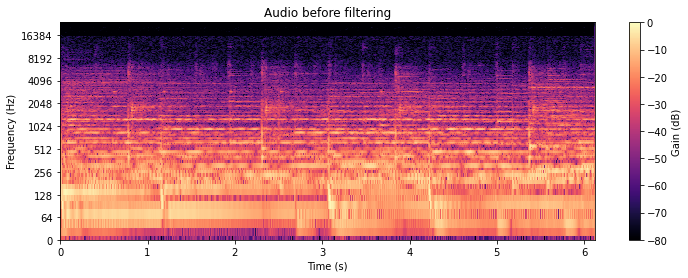

Python filtering complete. Filtered output saved to: ./test_audio/filtered_python.wav


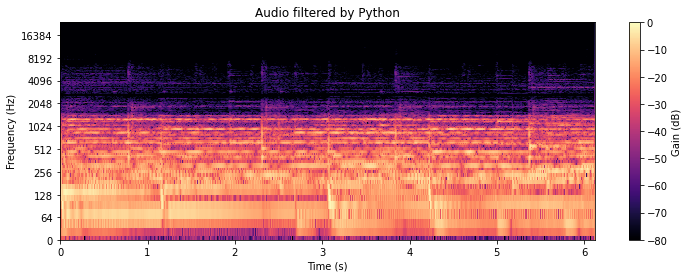

Pure Data filtering complete. Filtered output saved to: ./test_audio/filtered_pd.wav


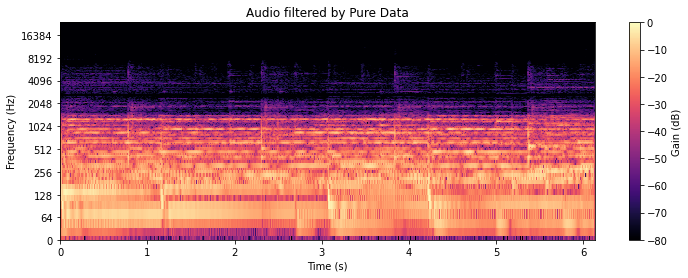

In [4]:
# Designing an IIR filter using SciPy signal
filt = signal.iirdesign(wp=0.05, ws=0.07, gpass=1, gstop=20, ftype="cheby2")

input_file = "./test_audio/to_be_filtered.wav" # Defines input file location
python_output_file = "./test_audio/filtered_python.wav" # Defines Python output file location
pd_output_file = "./test_audio/filtered_pd.wav" # Defines Pure Data output file location

# Before filtering
before_filtering = lib.load(input_file, sr=sr)[0] # Loads unfiltered audio file
spectrogram(before_filtering, "Audio before filtering") # Displays spectrogram of unfilitered signal
display(ipd.Audio(before_filtering, rate=sr)) # Allows playback of unfiltered signal

# Python filtering
python_filtered = apply_filter_python(filt, input_file, python_output_file) # Applies filter to test file using SciPy
spectrogram(python_filtered, "Audio filtered by Python") # Displays spectrogram of the filtered signal
display(ipd.Audio(python_filtered, rate=sr)) # Allows playback of the filtered audio

# Pure Data filtering
pd_filtered = apply_filter_pd(filt, input_file, pd_output_file) # Applies filter to test file using Pure Data
spectrogram(pd_filtered, "Audio filtered by Pure Data") # Displays spectrogram of the filtered signal
display(ipd.Audio(python_filtered, rate=sr)) # Allows playback of the filtered audio